# Annotation of single cell genomics data with a classifier
## Background
 We generated a gene expression dataset of stimulated and unstimulated human CD4 T cells. There are 20000 features (genes)
 and 4000 oberservations (cells). After clustering of the cells with Louvain clustering (after variable feature
 selection and principal component analysis) we get 5 clusters. We named theses as naïve, effector memory (2x),
 central memory and regulatory CD4 T cells based on the expression of 6 canonical markers (CCR7, SELL, CD27,
 IL2RA, IL7R, FOXP3). However there remains uncertainty about the correct naming and we would like to leverage
 the depth of the single cell dataset.
## Plan
 There is a labeled dataset curated by the Broad Institute containing 13000 Peripheral Blood Mononuclear Cells (PBMC)
 (https://portals.broadinstitute.org/single_cell/study/SCP345/immune-cell-atlas-pbmc-2- donors-2- sites).
 The labeling was done manually and by fitting their expression based on reference gene lists and again based on a Bayes classifier.
 I would like to train a random forest classifier with the Broad Institute’s data to label my own clusters correctly.
 Thereby using also cross validation and hyperparameter tuning.
 Challenges might be mainly batch effects between the training and the new dataset and also that the training dataset
 contains non-activated cells as opposed to activated cells in my (new) dataset.

## Setup

In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from scipy import stats
import anndata as ad # scanpy/anndata are used as a container for the genomics data
import collections
from yellowbrick.classifier import ConfusionMatrix
import itertools
import copy
  
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn import metrics
from sklearn import preprocessing

# Define datasets
# new: my dataset, train: the Broad's dataset, test: split subsample of the Broad's dataset
batch_categories = ["new", "train"]

file_new = './write/1Exp11-cd3_46.h5ad'
file_new_annot = './write/annotation_cd3_46_louvain03.csv'

file_train = './class-data/pbmc_site_bc.scp.expr.txt'
file_train_annot = './class-data/pbmc_cca_final_tsne_lineage1lineage2.txt'


## Preprocessing

### Annotate datasets and filter features

In [2]:
# Load new data + annotation
adata1 = sc.read_h5ad(file_new)

annotation1 = pd.read_csv(file_new_annot, header=None, dtype={0: str, 1: str})
adata1.obs['cluster'] = list(annotation1.iloc[:,1])
adata1.obs['cluster'] = adata1.obs['cluster'].astype('category')
adata1.obs['louvain_03'] = adata1.obs['cluster'] # save original clustering before modification

# Load training data + annotation
annotation2 = pd.read_csv(file_train_annot, sep="\t")
annotation2 = annotation2.drop([0]) # row 0 contains only metadata
annotation2 = annotation2[['NAME','T sub-lineages']]
annotation2
adata2 = sc.read_csv(file_train, delimiter='\t', first_column_names=True, dtype='float32').T # transpose!
adata2 = adata2[annotation2["NAME"],:] # remove non annotated cells

adata2.obs['cluster'] = list(annotation2['T sub-lineages']) # label observations in training data
adata2.obs['cluster'] = adata2.obs['cluster'].astype('category')

# Filter features/labels to match the datasets

# Only keep common features in both datasets
common_features = list(set(adata1.var_names.values).intersection(adata2.var_names.values))
adata1 = adata1[:,common_features]
adata2 = adata2[:,common_features]

# Only keep common labels + Rename the labels to match
adata2 = adata2[adata2.obs['cluster'].isin(['1. aTreg', '4. T4eff.mem', '5. T4naive']),:]
annotation2
# Match cluster names
mapping_table_new = {'cluster' : {'0': 'Tnaive', '1': 'Teff_mem', '2': 'Teff_mem', '3': 'Teff_mem', '4': 'Treg'}} # rename cluster to match
adata1.obs.replace(mapping_table_new, inplace=True)

mapping_table_train = {'cluster' : {'1. aTreg': 'Treg', '4. T4eff.mem': 'Teff_mem', '5. T4naive': 'Tnaive'}} # rename cluster to match
adata2.obs.replace(mapping_table_train, inplace=True)


#### Scale data
 Scaling appears to be the most important part of the preprocessing. I tested many different options and
 chose to renormalize both datasets with scanpy's builtin function.
 How do I recognize a "good"/"appropriate" scaling?

In [3]:
# keep copy of non-scaled data
adata1.raw = adata1
adata2.raw = adata2

# DEBUG: Copy data
# tmp_new = copy.deepcopy(adata1)
# tmp_test = copy.deepcopy(adata2)

# Option 1: Renormalize both datasets
sc.pp.normalize_per_cell(adata1, counts_per_cell_after=1e4)
sc.pp.log1p(adata1) #log transform
sc.pp.normalize_per_cell(adata2, counts_per_cell_after=1e4)
sc.pp.log1p(adata2) #log transform

# Option 2: Scale both datasets
# preprocessing.maxabs_scale(adata1.X, copy=False)
# preprocessing.maxabs_scale(adata2.X, copy=False)

# Option 3: Binarize both datasets
# binarizer = preprocessing.Binarizer(threshold=0, copy=False)
# binarizer.transform(adata1.X)
# binarizer.transform(adata2.X)
# binarizer = preprocessing.Binarizer(threshold=0, copy=True) # this needs to be added after HVG processing to not influence it!

# Option 4: Downsample the second train dataset
# sc.pp.calculate_qc_metrics(adata1, inplace=True)
# sc.pp.calculate_qc_metrics(adata2, inplace=True)
# adata2_counts = int(adata1.obs['total_counts'].mean() * len(adata2))
# sc.pp.downsample_counts(adata2, total_counts=adata2_counts, replace=True)

# Options 5: Use scanpy builtin scaling
#sc.pp.scale(adata1, max_value=10)
#sc.pp.scale(adata2, max_value=10)


### Visualize scaled genes

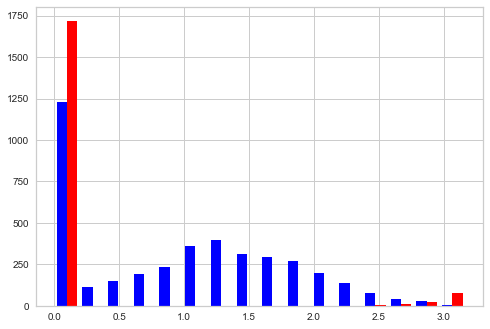

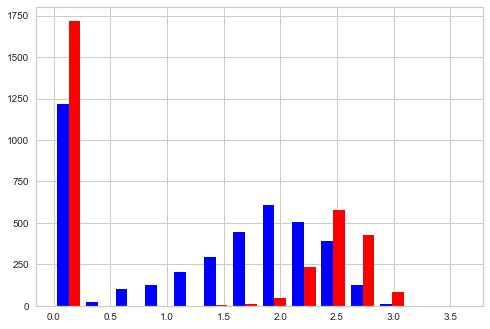

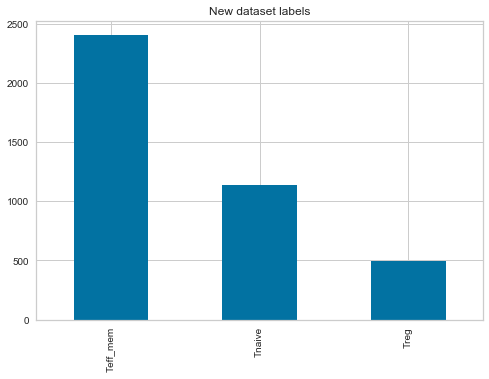

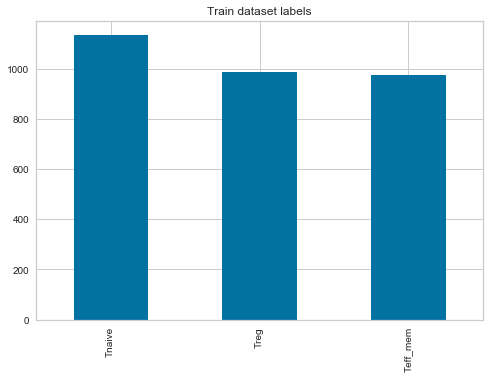

In [4]:
# Plot before scaling
plt.hist([adata1.raw[:,"CCR7"].X, adata2.raw[:,"CCR7"].X], bins='auto', color=["blue", "red"])
plt.show()
# Plot after scaling
plt.hist([adata1[:,"CCR7"].X, adata2[:,"CCR7"].X], bins='auto', color=["blue", "red"])
plt.show()

# Label distibution
adata1.obs['cluster'].value_counts().plot(kind='bar', title='New dataset labels')
plt.show()
adata2.obs['cluster'].value_counts().plot(kind='bar', title='Train dataset labels')
plt.show()

### Restrict features based on expression pattern
 Keep only highly variable genes in the dataset above an expression threshold.

In [5]:
# Option 1: Select highly variable genes combined from both datasets
sc.pp.highly_variable_genes(adata1, min_mean=0.0125, max_mean=4, min_disp=0.5)
sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=4, min_disp=0.5)
features_hvg_common = list(set(adata1.var_names[adata1.var['highly_variable'].values]).intersection(adata2.var_names[adata2.var['highly_variable'].values]))

# Option 2: Select HVGs only from one dataset
# features_hvg_new = adata1.var_names[adata1.var['highly_variable']].values
# features_hvg_train = adata2.var_names[adata2.var['highly_variable']].values

# Option 3: Select DEGs from clusters from new dataset
# features_DEG_new = pd.read_csv('./cd3_46_DEG_louvain03_top100.csv', skiprows=1, header=None)
# features_DEG_new = list(features_DEG_new.iloc[:,1:].to_numpy().flatten())
# features_DEG_new = list(set(features_DEG_new).intersection(common_features))


### Batch correction
 Did not work because no "anchoring" population present and batch effect probably bigger than population differences.
 Skipped.

In [6]:
# Batch correction (continue with feature-restricted dataset) 
# corrected = sc.external.pp.mnn_correct(adata1[:,common_hvg], adata2[:,common_hvg], k=160, batch_key='batch', batch_categories=batch_categories, var_subset=common_hvg, save_raw=True) # it replaces AnnData.concatenate(), time consuming!
# adata_mnn160 = corrected[0]
# adata_mnn40.write("./write/ml_project_aligned40_obj.h5ad") # save the 'freshly' batch corrected object
# adata_mnn = sc.read_h5ad("./write/ml_project_aligned_obj.h5ad")
# adata_mnn = adata_mnn[:,common_hvg]
#sc.pp.regress_out(adata_mnn, ['n_counts', 'percent_mito']) #??
# sc.pp.scale(adata_mnn, max_value=10)
# sc.tl.pca(adata_mnn, svd_solver='arpack')
#sc.pl.pca_variance_ratio(adata_mnn, log=True)

# sc.pp.neighbors(adata_mnn, n_pcs=21, method='umap')
#sc.tl.umap(adata_mnn)
# sc.tl.draw_graph(adata_mnn)

#sc.pl.draw_graph(adata_mnn, color=["batch", "cluster", "CCR7", "SELL", "CD69", "IFNG"])


### Define dataset for classifier

In [7]:
# Training labels
y = adata2.obs['cluster']

# Training data / restrict features
X = adata2[:,features_hvg_common].X #  # restrict by preselected features based on biological knowledge
# Split Training and Test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# New data
X_new = adata1[:,features_hvg_common].X # restrict by preselected features based on biological knowledge


## Classification

In [8]:
clf = RandomForestClassifier(n_estimators=1000, max_features="sqrt")
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# y_new = clf.predict(X_new)

rfecv = RFECV(estimator=clf, step=0.1, cv=3, verbose=2, scoring='accuracy')
selector = rfecv.fit(X_train, y_train)
y_pred = rfecv.predict(X_test)
y_new = rfecv.predict(X_new)


Fitting estimator with 1276 features.
Fitting estimator with 1149 features.
Fitting estimator with 1022 features.
Fitting estimator with 895 features.
Fitting estimator with 768 features.
Fitting estimator with 641 features.
Fitting estimator with 514 features.
Fitting estimator with 387 features.
Fitting estimator with 260 features.
Fitting estimator with 133 features.
Fitting estimator with 6 features.
Fitting estimator with 1276 features.
Fitting estimator with 1149 features.
Fitting estimator with 1022 features.
Fitting estimator with 895 features.
Fitting estimator with 768 features.
Fitting estimator with 641 features.
Fitting estimator with 514 features.
Fitting estimator with 387 features.
Fitting estimator with 260 features.
Fitting estimator with 133 features.
Fitting estimator with 6 features.
Fitting estimator with 1276 features.
Fitting estimator with 1149 features.
Fitting estimator with 1022 features.
Fitting estimator with 895 features.
Fitting estimator with 768 featur

## Quality metrics


Optimal number of features : 133 

0.88671875
0.0


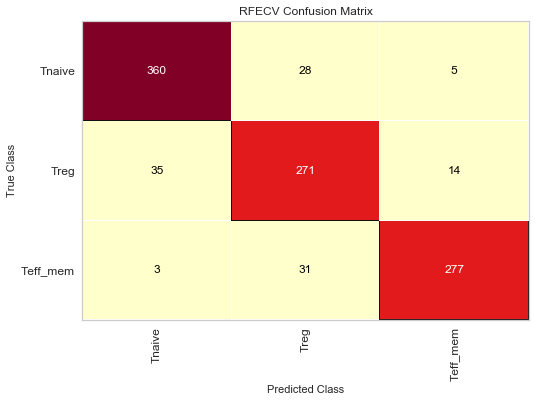

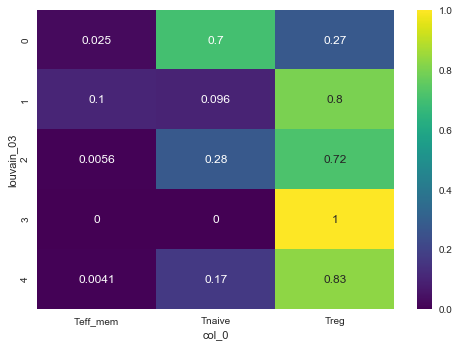

In [9]:
# Selected features
print("\nOptimal number of features : %d \n" % rfecv.n_features_)
# a = np.column_stack((rfecv.ranking_, adata2.var_names)) #combine ranks with genes
# a[a[:,0].argsort()][1:100,1] # print top100 ranks

#
# Training data
#

# Confusion Matrix
cm = ConfusionMatrix(rfecv, classes=["Tnaive", "Treg", "Teff_mem"])
cm.score(X_test, y_test)
cm.poof()

print(metrics.accuracy_score(y_test, y_pred))

#
# New data
#

# Confusion matrix
y_louvain = adata1.obs['louvain_03'] #cluster
df_conf_norm = pd.crosstab(y_louvain, y_new, normalize='index') # + normalize
sns.heatmap(df_conf_norm, annot=True, cmap="viridis")

# Test accuracy
print(metrics.accuracy_score(y_louvain, y_new))



## Visualizing predicted labels on UMAP plot of new dataset
 To visually compare prediction and manual annotation.

... storing 'cluster' as categorical
... storing 'labels_pred' as categorical


saving figure to file ./figures/draw_graph_farandom_forest_pred.pdf


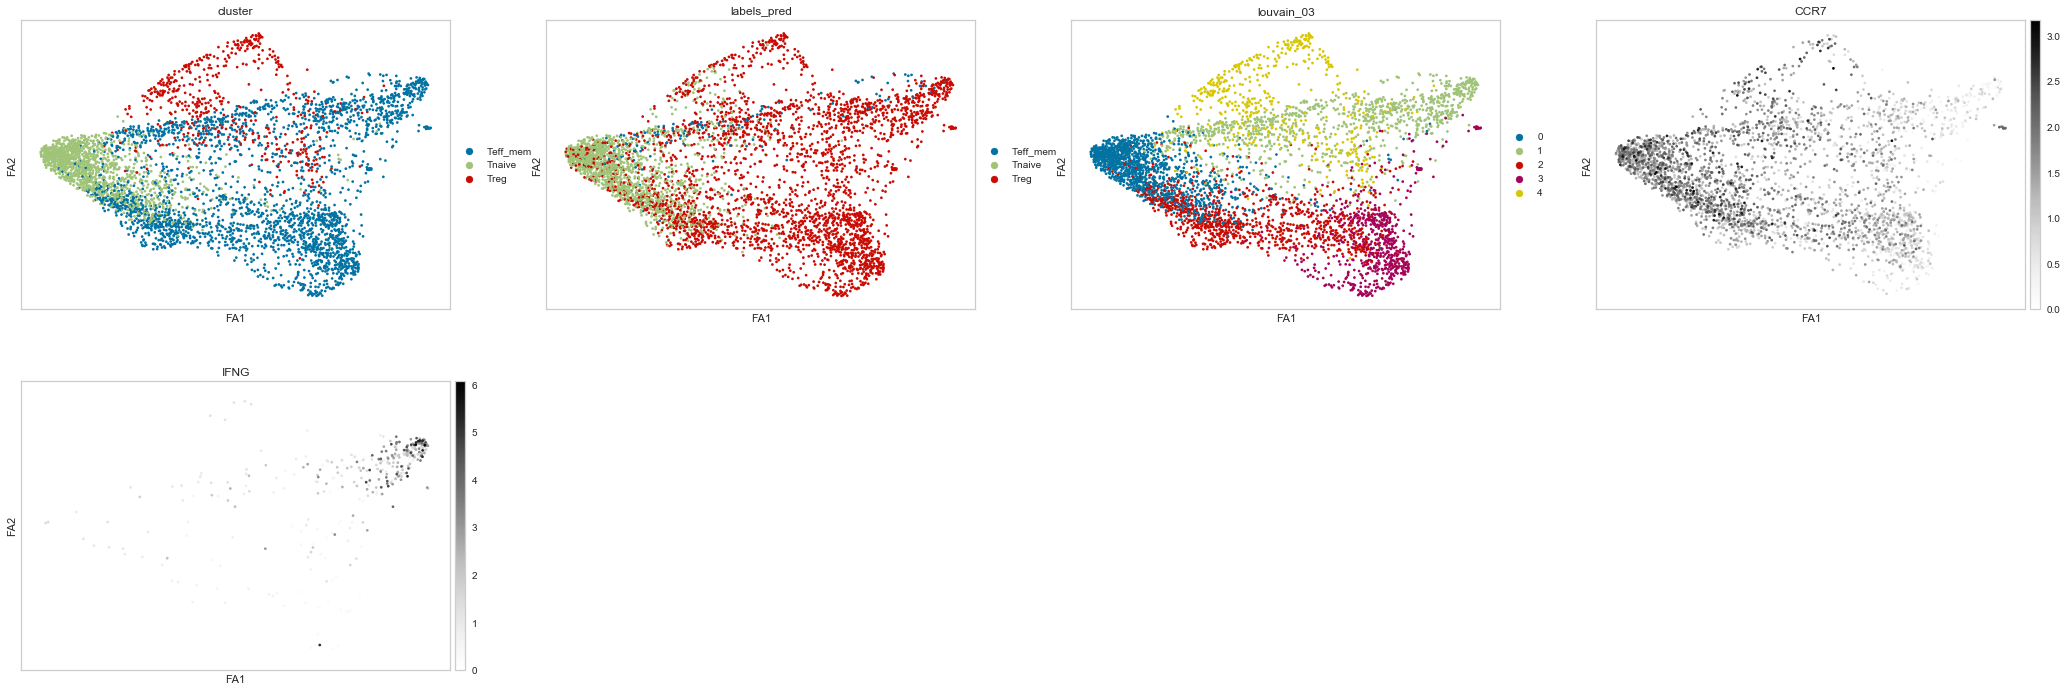

In [10]:
# Constructing UMAP
sc.pp.scale(adata1, max_value=10)
sc.tl.pca(adata1, svd_solver='arpack')
sc.pp.neighbors(adata1, n_pcs=21, method='umap')
sc.tl.draw_graph(adata1)

# Add predicted labels to new dataset
adata1.obs['labels_pred'] = y_new
# Drawing labels on scatter plot
sc.pl.draw_graph(adata1, color=['cluster','labels_pred', 'louvain_03', 'CCR7', 'IFNG'], save='random_forest_pred') # add two genes and old clustering for orientation in the plot